# Baseline solution for Tiny ImageNet Challenge

You are presented with an opportunity to implement an Image Classifier for Tiny ImageNet dataset [same as used in CS231N](LINK). Tiny ImageNet contains 200 classes for training. Each class has 500 images. The test set contains 10,000 images. All images are 64x64 colored ones.

Your final goal is to demonstrate solid performance on the test split of the Tiny ImageNet dataset. We encourage you to show your thinking and demonstrate as many best practices along the way as you find appropriate.

We are looking for good analysis and presentation of the results, good problem decomposition and enough structure to allow for future foreseeable improvements. 

In [8]:
%%capture

from dataclasses import dataclass, replace
from pathlib import Path
from typing import Callable, List, Optional, Sequence, Union

import pandas as pd
import torch
import os
from pandas import DataFrame
from PIL import Image
from torch.utils.data.dataloader import default_collate
from torch.utils.data.dataset import Dataset
import sklearn
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
from PIL import Image
from torchvision import transforms

from torchvision import models
from torch.nn.modules import loss
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from tqdm.auto import tqdm

# Getting the data

In [11]:
DATA_PATH = Path("/data")
DATA_PATH.mkdir(exist_ok=True)

In [17]:
! [ ! $DATA_PATH/tiny-imagenet-200.zip ] && wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip -O $DATA_PATH/tiny-imagenet-200.zip

Unpacking our dataset will take a while, but it will only have to be done once.

Be prepared to wait next cell to finish up to 15 minutes

In [20]:
! [ ! -d $DATA_PATH/tiny-imagenet-200 ] && unzip -q $DATA_PATH/tiny-imagenet-200.zip -d $DATA_PATH
! ls $DATA_PATH

tiny-imagenet-200  tiny-imagenet-200.zip


# Dataset

Here is a `TinyImagenetDataset` warpper you might find useful.

In [14]:
Transform = Callable[[Image.Image], Image.Image]


@dataclass()
class ItemsBatch:
    images: torch.Tensor
    labels: torch.Tensor
    ids: List[int]
    paths: List[Path]
    items: List["DatasetItem"]


@dataclass()
class DatasetItem:
    image: Union[torch.Tensor, Image.Image]
    label: int
    id: int
    path: Path

    @classmethod
    def collate(cls, items: Sequence["DatasetItem"]) -> ItemsBatch:
        if not isinstance(items, list):
            items = list(items)
        return ItemsBatch(
            images=default_collate([item.image for item in items]),
            labels=default_collate([item.label for item in items]),
            ids=[item.id for item in items],
            paths=[item.path for item in items],
            items=items,
        )

In [21]:
DATA_ROOT = DATA_PATH / "tiny-imagenet-200"
RESULTS_ROOT = Path("/project/results/")
CHECKPOINTS = RESULTS_ROOT / "checkpoints"
CHECKPOINTS.mkdir(parents=True, exist_ok=True)
TENSORBOARD_TAG = "first_try"
CKPT_NAME = "first_model.pth"
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [22]:
TRAIN_PATH = DATA_ROOT / "train"
VAL_PATH = DATA_ROOT / "val"
ALL_FOLDERS = [
    dir_name
    for r, d, f in os.walk(TRAIN_PATH)
    for dir_name in d
    if dir_name != "images"
]
FOLDERS_TO_NUM = {val: index for index, val in enumerate(ALL_FOLDERS)}

LABELS = pd.read_csv(
    DATA_ROOT / "words.txt", sep="\t", header=None, index_col=0)[1].to_dict()
VAL_LABELS = pd.read_csv(
    DATA_ROOT / "val" / "val_annotations.txt", sep="\t", header=None, index_col=0)[1].to_dict()

In [23]:
class TinyImagenetDataset(Dataset):
    _transform: Optional[Transform]
    _root: Path
    _df: DataFrame

    def __init__(self, path, transform: Optional[Transform] = None):
        self._transform = transform
        if not os.path.isdir(path):
            raise NotADirectoryError(f"{path} is not a directory.")
        all_files = [
            os.path.join(r, fyle)
            for r, d, f in os.walk(path)
            for fyle in f
            if ".JPEG" in fyle
        ]
        labels = [
            FOLDERS_TO_NUM.get(
                os.path.basename(f).split("_")[0],
                FOLDERS_TO_NUM.get(VAL_LABELS.get(os.path.basename(f))),
            )
            for f in all_files
        ]
        self._df = pd.DataFrame({"path": all_files, "label": labels})

    def __getitem__(self, index: int) -> DatasetItem:
        path, label = self._df.loc[index, :]
        image = Image.open(path).convert("RGB")
        if self._transform:
            image = self._transform(image)
        return DatasetItem(image=image, label=label, id=index, path=path)

    def __len__(self) -> int:
        return len(self._df)

# Training loop

This is a very basic training pipeline intended to rid you of writing too much boilerplate code

In [24]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]
)

train_dataset = TinyImagenetDataset(DATA_ROOT / "train", transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=0,
)

test_dataset = TinyImagenetDataset(DATA_ROOT / "val" / "images", transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=0,
)

In [25]:
def train(model, device, train_loader, optimizer, loss_function, epoch, writer):
    model.train()
    model.to(device)
    correct = 0
    for batch_idx, batch_data in enumerate(tqdm(train_loader)):
        data, target = batch_data.images.to(device), batch_data.labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print(
        "Train Epoch: {} [ ({:.0f}%)]\tLoss: {:.6f}".format(
            epoch, 100.0 * correct / len(train_loader.dataset), loss.item()
        )
    )
    writer.add_scalar("train_loss_plot", loss.item(), global_step=epoch)
    writer.add_scalar(
        "train_accuracy_plot",
        100.0 * correct / len(train_loader.dataset),
        global_step=epoch,
    )


def test(model, device, test_loader, loss_function, epoch, writer):
    model.eval()
    model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(test_loader)):
            data, target = batch_data.images.to(device), batch_data.labels.to(device)
            output = model(data)
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    writer.add_scalar("test_loss_plot", test_loss, global_step=epoch)
    writer.add_scalar(
        "test_accuracy_plot",
        100.0 * correct / len(test_loader.dataset),
        global_step=epoch,
    )

In [26]:
model = models.resnet18()
model.fc = nn.Linear(512, 200)
model = model.to(DEVICE)

optimizer = optim.SGD(model.parameters(), lr=1e-3)

loss_function = loss.CrossEntropyLoss()

Please notice, that we added `break` in the training loop, your baseline basically is a `resnet18` without fine-tuning

Also we pre-set for you `tensorboard` output path, so it would be easier for us to follow your results

In [27]:
for epoch in range(1):
    writer = SummaryWriter(RESULTS_ROOT / TENSORBOARD_TAG)
    break  # You should probably remove this in your training loop

    train(model, DEVICE, train_loader, optimizer, loss_function, epoch, writer)
    test(model, DEVICE, test_loader, loss_function, epoch, writer)
    writer.close()

# Visualisation

Here is also a confusion matrix plot for you

In [28]:
import sklearn
import numpy as np
from matplotlib import pyplot as plt

In [29]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([200, 200], int)

with torch.no_grad():
    for item in tqdm(test_loader):
        images, labels = item.images.to(DEVICE), item.labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1

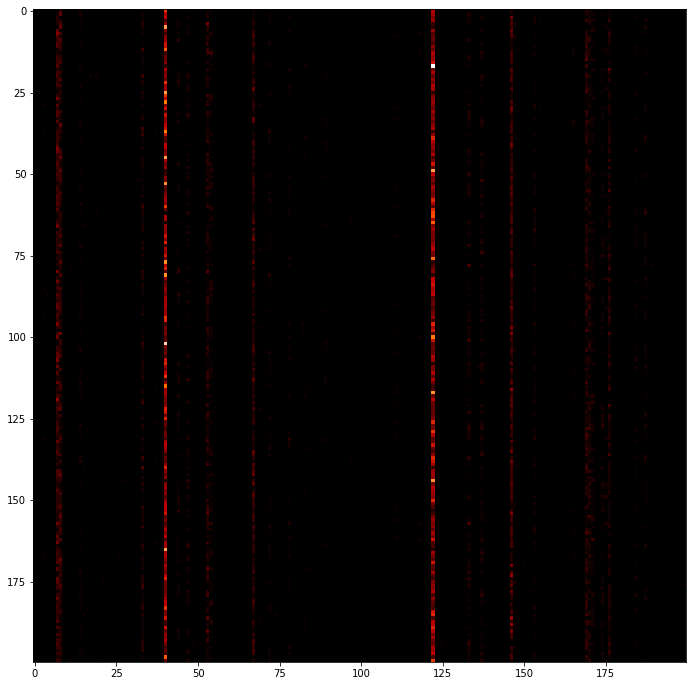

In [30]:
plt.figure(figsize=(12, 12))
plt.imshow(confusion_matrix, cmap="gist_heat", interpolation="nearest")
plt.show()